In [1]:
from process_helper import *
import numpy as np

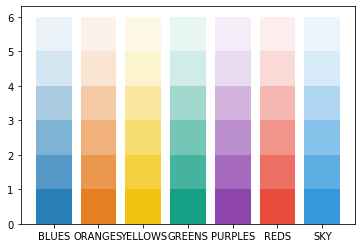

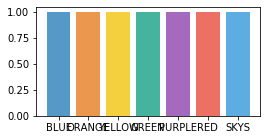

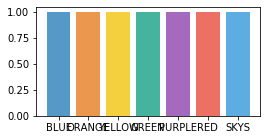

<Figure size 288x144 with 0 Axes>

In [2]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(4)
_, line_colors = select_color_idx(4)

In [3]:
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

In [4]:
datadir = "../output/"
path = "/Users/scarlet/Desktop/Bonsai/figures/"

In [6]:
def make_bar_graph(df, col, ylabel="Abort Rate", scale=1, ylim=-1):
    # set values
    xvals = df.index.levels[1]
    xticks = np.arange(len(xvals)) 
    # set format
    bar_space = 0.2
    width = (1.0 - bar_space) / len(df.index.levels[0])
    fig, ax = plt.subplots(1, 1)
    # OBJBUF
    ax.bar(xticks, df.loc["OBJBUF", col] * scale, label="Bonsai",
           width=width, edgecolor="black", hatch="\\\\", facecolor=bar_colors["BLUE"])
    # PGBUF
    ax.bar(xticks + width, df.loc["PGBUF", col] * scale, label="Page-Index",
           width=width, edgecolor="black", hatch="//", facecolor=bar_colors["GREEN"])
    # NOBUF
    vals3 = np.repeat(df.loc["NOBUF", col].values * scale, len(df.loc["OBJBUF", col]))
    ax.bar(xticks + width*2, vals3, label="Remote-Index",
           width=width, edgecolor="black", facecolor=bar_colors["ORANGE"])
    if ylim != -1:
        ax.set_ylim(0, ylim)
    plt.xticks(xticks + width, ["0.3", "0.6", "0.9", "1.3"])
    ax.set_xlabel("Buffer Size / Data Size")
    ax.set_ylabel(ylabel)
    fig.set_size_inches(6, 2.5)
    plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
    plt.legend(frameon=False, loc='upper left') #labelspacing = 0.07, bbox_to_anchor=(0.2, 1)
    return fig, ax

## Load Data

In [7]:
def load_data(exp):
    data = [json.loads(line) for line in open(datadir + exp + ".txt")]
    df = pd.DataFrame().from_records(data)
    total = (df["insert_commit_cnt_"] + df["scan_commit_cnt_"] + df["rw_commit_cnt_"]) * 1.0
    df["scan_commit_ratio"] = df["scan_commit_cnt_"] / total
    df["rw_commit_ratio"] = df["rw_commit_cnt_"] / total
    df["corrected_scan_commit_cnt"] = df["scan_commit_ratio"] * df["commit_cnt_"]
    df["corrected_rw_commit_cnt"] = df["rw_commit_ratio"] * df["commit_cnt_"]
    df["abort_rate"] = df["abort_cnt_"]*1.0 / (df["abort_cnt_"] + df["commit_cnt_"])
    return df

In [8]:
exp2 = load_data("exp_scan_10g_fanout250_analysis")
exp3 = load_data("exp_ycsbe_10g_fanout250_analysis")
exp4 = load_data("exp_mix_ro_10g_fanout250_analysis")
exp5 = load_data("exp_ycsbe_scan_analysis")

In [9]:
exp4.columns.values

array(['abort_cnt_', 'accesses_', 'avg_commit_queue_sz_',
       'avg_log_flush_interval_ (us)', 'avg_log_group_sz_',
       'avg_log_latency_ (us)', 'avg_per_worker_runtime_sec',
       'avg_sum_commit_latency (us)', 'avg_sum_log_flush_latency (us)',
       'bufferd_idx_pgs_', 'cc_time_ms', 'commit_cnt_',
       'commit_latency_perc0_us', 'commit_latency_perc50_us',
       'commit_latency_perc99_us', 'commit_queue_sz_', 'g_buf_entry_sz',
       'g_buf_type', 'g_check_loaded', 'g_commit_group_sz',
       'g_commit_pool_sz', 'g_commit_queue_limit', 'g_cpu_freq',
       'g_early_lock_release', 'g_enable_group_commit',
       'g_enable_logging', 'g_enable_phantom_protection', 'g_force_write',
       'g_idx_btree_fanout', 'g_idx_btree_split_ratio', 'g_index_type',
       'g_load_range', 'g_load_to_remote_only', 'g_log_freq_us',
       'g_node_id', 'g_num_restore_thds', 'g_num_worker_threads',
       'g_pagebuf_num_slots', 'g_partition_sz', 'g_remote_req_retries',
       'g_restore_from_rem

In [10]:
def get_diff(result, col1, col2):
    diff = result[col2] - result[col1]
    return diff

def get_speedup(result, col1, col2):
    diff = get_diff(result, col1, col2)
    return [(result[col2][i] / result[col1][i] - 1)*100 if x > 0 
                                 else -(result[col1][i] / result[col2][i] - 1) * 100 for i, x in enumerate(diff)]
    
def get_compare(col="throughput_txn_per_sec", mask=[], divided_by="", use_diff=False):
    data2 = apply_mask(exp2, mask)
    data3 = apply_mask(exp3, mask)
    data4 = apply_mask(exp4, mask)
    result = data2.groupby(["g_buf_type", "g_total_buf_sz"])[col].max().reset_index().set_index(
        ["g_buf_type", "g_total_buf_sz"])
    result3 = data3.groupby(["g_buf_type", "g_total_buf_sz"])[col].max()
    result4 = data4.groupby(["g_buf_type", "g_total_buf_sz"])[col].max()
    if isinstance(col, str):
        result.rename(columns={col: "exp2"}, inplace=True)
        result["exp3"] = result3
        result["exp4"] = result4
        if divided_by != "":
            result["exp2"] /= data2.groupby(["g_buf_type", "g_total_buf_sz"])[divided_by].max()
            result["exp3"] /= data3.groupby(["g_buf_type", "g_total_buf_sz"])[divided_by].max()
            result["exp4"] /= data4.groupby(["g_buf_type", "g_total_buf_sz"])[divided_by].max()
        if use_diff:
            result["diff3_2"] = get_diff(result, "exp2", "exp3")
            result["diff4_2"] = get_diff(result, "exp2", "exp4")
        else:
            result["speedup3_2"] = get_speedup(result, "exp2", "exp3")
            result["speedup4_2"] = get_speedup(result, "exp2", "exp4")
        return result
    else:
        reorder = []
        dic2 = {}
        for c in col:
            dic2[c] = "exp2_" + c
            result["exp3_" + c] = result3[c]
            result["exp4_" + c] = result4[c]
            reorder += ["exp2_"+c, "exp3_"+c, "exp4_"+c]
            if use_diff:
                result["diff3_2_" + c] = get_diff(result, c, "exp3_" + c)
                result["diff4_2_" + c] = get_diff(result, c, "exp4_" + c)
                reorder += ["diff3_2_"+c, "diff4_2_"+c]
            else:
                result["speedup3_2_" + c] = get_speedup(result, c, "exp3_" + c)
                result["speedup4_2_" + c] = get_speedup(result, c, "exp4_" + c)
                reorder += ["speedup3_2_"+c, "speedup4_2_"+c]
        result.rename(columns=dic2, inplace=True)
        return result.loc[:, reorder]
    
def compare_rw_ro(col="throughput_txn_per_sec", mask=[], divided_by="", use_diff=False):
    data5 = apply_mask(exp5, mask)
    data4 = apply_mask(exp4, mask)
    result = data5.groupby(["g_buf_type", "g_total_buf_sz"])[col].max().reset_index().set_index(
        ["g_buf_type", "g_total_buf_sz"])
    result4 = data4.groupby(["g_buf_type", "g_total_buf_sz"])[col].max()
    if isinstance(col, str):
        result.rename(columns={col: "rw"}, inplace=True)
        result["ro"] = result4
        if divided_by != "":
            result["rw"] /= data5.groupby(["g_buf_type", "g_total_buf_sz"])[divided_by].max()
            result["ro"] /= data4.groupby(["g_buf_type", "g_total_buf_sz"])[divided_by].max()
        if use_diff:
            result["diff_rw_ro"] = get_diff(result, "rw", "ro")
        else:
            result["speedup_rw_ro"] = get_speedup(result, "rw", "ro")
        return result
    else:
        reorder = []
        dic2 = {}
        for c in col:
            dic2[c] = "rw_" + c
            result["ro_" + c] = result4[c]
            reorder += ["rw_"+c, "ro_"+c]
            if use_diff:
                result["diff_rw_ro_" + c] = get_diff(result, c, "ro_" + c)
                reorder += ["diff_rw_ro_"+c]
            else:
                result["speedup_rw_ro_" + c] = get_speedup(result, c, "ro_" + c)
                reorder += ["speedup_rw_ro_"+c]
        result.rename(columns=dic2, inplace=True)
        return result.loc[:, reorder]

## Compare throughput

In [11]:
get_compare(col="scan_commit_ratio")

exp2      exp3      exp4  speedup3_2  speedup4_2
g_buf_type g_total_buf_sz                                                  
NOBUF      3000000000       1.0  0.947826  0.948383   -5.504587   -5.442656
OBJBUF     3000000000       1.0  0.949118  0.949209   -5.360946   -5.350915
           6000000000       1.0  0.950338  0.948860   -5.225760   -5.389667
           9000000000       1.0  0.949736  0.949060   -5.292384   -5.367419
           15000000000      1.0  0.949734  0.949062   -5.292593   -5.367152
PGBUF      3000000000       1.0  0.949216  0.949084   -5.350090   -5.364726
           6000000000       1.0  0.950100  0.948881   -5.252079   -5.387295
           9000000000       1.0  0.950219  0.948638   -5.238916   -5.414290
           15000000000      1.0  0.950277  0.950115   -5.232497   -5.250390

In [12]:
get_compare(col="corrected_scan_commit_cnt", divided_by="runtime_")

exp2         exp3         exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                                      
NOBUF      3000000000       180.033333   165.032319   165.413765   -9.089744   
OBJBUF     3000000000      1005.150000  1049.803913  1002.997141    4.442512   
           6000000000      2472.666667  2111.143378  2285.217715  -17.124526   
           9000000000      6723.516667  6202.870281  6301.884799   -8.393637   
           15000000000     8083.050000  6409.963404  6782.363583  -26.101344   
PGBUF      3000000000      1241.933333  1227.478778  1188.759640   -1.177581   
           6000000000      2011.100000  1930.175648  2003.894303   -4.192590   
           9000000000      3257.633333  3323.707102  3176.767277    2.028275   
           15000000000     7698.266667  6313.813260  7083.029969  -21.927373   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000       -8.838182  
OBJBUF     3000000000       -0.214643  
           6000000000       -8.202674  
           9000000000       -6.690568  
           15000000000     -19.177480  
PGBUF      3000000000       -4.473040  
           6000000000       -0.359585  
           9000000000       -2.545546  
           15000000000      -8.686067

In [14]:
get_compare(col="corrected_rw_commit_cnt", divided_by="runtime_", use_diff=True)

exp2        exp3        exp4     diff3_2  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000       0.0    9.084348    9.002902    9.084348   
OBJBUF     3000000000       0.0   56.279421   53.669525   56.279421   
           6000000000       0.0  110.323288  123.165618  110.323288   
           9000000000       0.0  328.279719  338.248535  328.279719   
           15000000000      0.0  339.253263  364.019750  339.253263   
PGBUF      3000000000       0.0   65.671222   63.773694   65.671222   
           6000000000       0.0  101.374352  107.955697  101.374352   
           9000000000       0.0  174.126231  171.999390  174.126231   
           15000000000      0.0  330.370074  371.886697  330.370074   

                              diff4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000        9.002902  
OBJBUF     3000000000       53.669525  
           6000000000      123.165618  
           9000000000      338.248535  
           15000000000     364.019750  
PGBUF      3000000000       63.773694  
           6000000000      107.955697  
           9000000000      171.999390  
           15000000000     371.886697

In [15]:
throughput = get_compare(col="throughput_txn_per_sec")
throughput

exp2       exp3       exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                                
NOBUF      3000000000        89.9322    86.9045    87.1127   -3.483939   
OBJBUF     3000000000       501.9230   552.2620   527.2480   10.029228   
           6000000000      1234.3800  1109.5800  1202.3200  -11.247499   
           9000000000      3352.4600  3263.6800  3316.7100   -2.720242   
           15000000000     4001.1000  3370.5600  3532.5000  -18.707277   
PGBUF      3000000000       617.9100   643.9010   608.8670    4.206276   
           6000000000       986.0980   980.0280  1021.7300   -0.619370   
           9000000000      1560.6400  1706.4300  1598.8100    9.341680   
           15000000000     3847.4300  3319.1400  3727.8200  -15.916472   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000       -3.236612  
OBJBUF     3000000000        5.045595  
           6000000000       -2.666511  
           9000000000       -1.077875  
           15000000000     -13.265393  
PGBUF      3000000000       -1.485218  
           6000000000        3.613434  
           9000000000        2.445791  
           15000000000      -3.208578

### Observation1: all in memory的throughput会下降 15% (page), 18% (bonsai), 3% remote

In [16]:
compare_rw_ro("scan_txn_user_latency_ms", divided_by="scan_commit_cnt_")

rw         ro  speedup_rw_ro
g_buf_type g_total_buf_sz                                        
OBJBUF     3000000000      1.603934e+01  15.936327  -6.464232e-01
           6000000000      8.850158e+07   6.982297  -1.267514e+09
           9000000000      1.706969e+08   2.486408  -6.865202e+09
           15000000000     1.370495e+08   2.265055  -6.050604e+09

* hypothesis 1: aborts causing degradation. (validated)

In [17]:
get_compare(mask=[
    ["g_total_buf_sz", ["eq", 15000000000]]
], col="abort_cnt_", use_diff=True)

,,exp2,exp3,exp4,diff3_2,diff4_2
g_buf_type,g_total_buf_sz,,,,,
OBJBUF,15000000000,0,41440,0,41440,0
PGBUF,15000000000,0,34887,0,34887,0


In [18]:
abort_rate = get_compare(col="abort_rate", use_diff=True)
abort_rate

exp2      exp3  exp4   diff3_2  diff4_2
g_buf_type g_total_buf_sz                                         
NOBUF      3000000000       0.0  0.000383   0.0  0.000383      0.0
OBJBUF     3000000000       0.0  0.000000   0.0  0.000000      0.0
           6000000000       0.0  0.003111   0.0  0.003111      0.0
           9000000000       0.0  0.007886   0.0  0.007886      0.0
           15000000000      0.0  0.092833   0.0  0.092833      0.0
PGBUF      3000000000       0.0  0.000000   0.0  0.000000      0.0
           6000000000       0.0  0.096614   0.0  0.096614      0.0
           9000000000       0.0  0.104268   0.0  0.104268      0.0
           15000000000      0.0  0.080470   0.0  0.080470      0.0

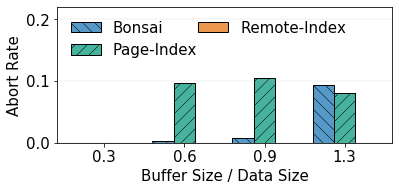

In [22]:
fig, ax = make_bar_graph(abort_rate, "exp3", ylabel="Abort Rate", ylim=0.22)
plt.legend(frameon=False, ncol=2, columnspacing = 0.1, loc='upper left')
fig.savefig(path + "ycsbe_10g_fanout250_limit16k_record_abort.pdf", bbox_inches="tight") 

* hypothesis 2: scan total latency increases due to abort but each round remains the same. (invalidated)
    * each round increases significantly as well 16\% in bonsai and 14\% in page-based

In [23]:
get_compare(mask=[
    ["g_total_buf_sz", ["eq", 15000000000]]
], col="scan_txn_latency_ms", divided_by="scan_commit_cnt_", use_diff=False)

,,exp2,exp3,exp4,speedup3_2,speedup4_2
g_buf_type,g_total_buf_sz,,,,,
OBJBUF,15000000000,1.999386,2.386113,2.265141,19.342304,13.291857
PGBUF,15000000000,2.079238,2.417723,2.155792,16.279298,3.681813


* why scan latency increases? 
    * logging latency increases significantly, more than 15\%
    * why? write operation needs to log the changes while scan operation does not. 

In [24]:
get_compare(col="avg_log_latency_ (us)", use_diff=False)

exp2      exp3      exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000      12174.60  12638.00  11592.60    3.806285   
OBJBUF     3000000000       3403.36   2958.12   3156.89  -15.051452   
           6000000000       1863.84   1983.76   1894.54    6.434029   
           9000000000       2021.06   2408.43   2186.96   19.166675   
           15000000000      1996.91   2370.42   2260.39   18.704398   
PGBUF      3000000000       5534.77   5640.04   5585.80    1.901976   
           6000000000       3954.68   4069.24   3964.31    2.896821   
           9000000000       2926.63   3091.71   2898.12    5.640617   
           15000000000      2058.49   2408.18   2219.20   16.987695   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000       -5.020444  
OBJBUF     3000000000       -7.807367  
           6000000000        1.647137  
           9000000000        8.208564  
           15000000000      13.194385  
PGBUF      3000000000        0.921990  
           6000000000        0.243509  
           9000000000       -0.983741  
           15000000000       7.807179

In [25]:
get_compare(mask=[
    ["g_total_buf_sz", ["eq", 15000000000]]
], col="avg_log_group_sz_", use_diff=False)

,,exp2,exp3,exp4,speedup3_2,speedup4_2
g_buf_type,g_total_buf_sz,,,,,
OBJBUF,15000000000,827.616,829.822,834.208,0.266549,0.796505
PGBUF,15000000000,824.814,825.364,845.436,0.066682,2.500200


## scan size

In [26]:
scan_sz = get_compare(mask=[
    ["g_buf_type", ["ne", "PGBUF"]]
], col=[
    'remote_scan_sz_perc0', 'remote_scan_sz_perc25', 
    'remote_scan_sz_perc50', 'remote_scan_sz_perc75',
    'remote_scan_sz_perc100'
], use_diff=True)
scan_sz

exp2_remote_scan_sz_perc0  \
g_buf_type g_total_buf_sz                              
NOBUF      3000000000                            2.0   
OBJBUF     3000000000                            0.0   
           6000000000                            0.0   
           9000000000                            0.0   
           15000000000                           NaN   

                           exp3_remote_scan_sz_perc0  \
g_buf_type g_total_buf_sz                              
NOBUF      3000000000                            2.0   
OBJBUF     3000000000                            0.0   
           6000000000                            0.0   
           9000000000                            0.0   
           15000000000                           NaN   

                           exp4_remote_scan_sz_perc0  \
g_buf_type g_total_buf_sz                              
NOBUF      3000000000                            2.0   
OBJBUF     3000000000                            0.0   
           6000000000                            0.0   
           9000000000                            0.0   
           15000000000                           NaN   

                           diff3_2_remote_scan_sz_perc0  \
g_buf_type g_total_buf_sz                                 
NOBUF      3000000000                               0.0   
OBJBUF     3000000000                               0.0   
           6000000000                               0.0   
           9000000000                               0.0   
           15000000000                              NaN   

                           diff4_2_remote_scan_sz_perc0  \
g_buf_type g_total_buf_sz                                 
NOBUF      3000000000                               0.0   
OBJBUF     3000000000                               0.0   
           6000000000                               0.0   
           9000000000                               0.0   
           15000000000                              NaN   

                           exp2_remote_scan_sz_perc25  \
g_buf_type g_total_buf_sz                               
NOBUF      3000000000                            27.0   
OBJBUF     3000000000                            25.0   
           6000000000                            22.0   
           9000000000                            19.0   
           15000000000                            NaN   

                           exp3_remote_scan_sz_perc25  \
g_buf_type g_total_buf_sz                               
NOBUF      3000000000                            27.0   
OBJBUF     3000000000                            24.0   
           6000000000                            23.0   
           9000000000                            19.0   
           15000000000                            NaN   

                           exp4_remote_scan_sz_perc25  \
g_buf_type g_total_buf_sz                               
NOBUF      3000000000                            28.0   
OBJBUF     3000000000                            24.0   
           6000000000                            23.0   
           9000000000                            19.0   
           15000000000                            NaN   

                           diff3_2_remote_scan_sz_perc25  \
g_buf_type g_total_buf_sz                                  
NOBUF      3000000000                                0.0   
OBJBUF     3000000000                               -1.0   
           6000000000                                1.0   
           9000000000                                0.0   
           15000000000                               NaN   

                           diff4_2_remote_scan_sz_perc25  ...  \
g_buf_type g_total_buf_sz                                 ...   
NOBUF      3000000000                                1.0  ...   
OBJBUF     3000000000                               -1.0  ...   
           6000000000                                1.0  ...   
           9000000000                                0.0  ...   
         

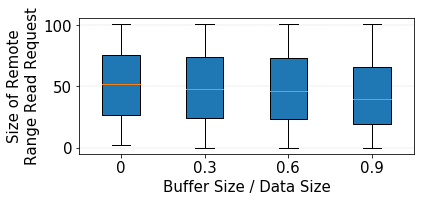

In [42]:
data = [["exp" + str(i) + "_remote_scan_sz_perc" + str(j) for j in [0, 25, 50, 75, 100]] for i in range(2, 5)]
fig, ax = plt.subplots()
i = 1
xvals = scan_sz.index.levels[1][:-1]
vals = [scan_sz.loc["NOBUF"].loc[:, data[i]].values] + [scan_sz.loc["OBJBUF"].loc[x, data[i]].values for x in xvals]
ax.boxplot(vals, vert=True, patch_artist=True, 
           labels=[0, 0.3, 0.6, 0.9], showfliers=False)
ax.set_xlabel("Buffer Size / Data Size")
ax.set_ylabel("Size of Remote\nRange Read Request")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
fig.set_size_inches(6, 2.5)
path = "/Users/scarlet/Desktop/Bonsai/figures/"
fig.savefig(path + "ycsbe_10g_fanout250_limit16k_remote_scan_sz.pdf", bbox_inches="tight") 

In [29]:
num_scans = get_compare(mask=[
    ["g_buf_type", ["eq", "OBJBUF"]]
], col=[
    'txn_scans_perc0', 'txn_scans_perc25', 
    'txn_scans_perc50', 'txn_scans_perc75',
    'txn_scans_perc100'
], use_diff=True)
num_scans

exp2_txn_scans_perc0  exp3_txn_scans_perc0  \
g_buf_type g_total_buf_sz                                               
OBJBUF     3000000000                       0.0                   0.0   
           6000000000                       0.0                   0.0   
           9000000000                       0.0                   0.0   
           15000000000                      0.0                   0.0   

                           exp4_txn_scans_perc0  diff3_2_txn_scans_perc0  \
g_buf_type g_total_buf_sz                                                  
OBJBUF     3000000000                       0.0                      0.0   
           6000000000                       0.0                      0.0   
           9000000000                       0.0                      0.0   
           15000000000                      0.0                      0.0   

                           diff4_2_txn_scans_perc0  exp2_txn_scans_perc25  \
g_buf_type g_total_buf_sz                                                   
OBJBUF     3000000000                          0.0                    0.0   
           6000000000                          0.0                    0.0   
           9000000000                          0.0                    0.0   
           15000000000                         0.0                    0.0   

                           exp3_txn_scans_perc25  exp4_txn_scans_perc25  \
g_buf_type g_total_buf_sz                                                 
OBJBUF     3000000000                        0.0                    0.0   
           6000000000                        0.0                    0.0   
           9000000000                        0.0                    0.0   
           15000000000                       0.0                    0.0   

                           diff3_2_txn_scans_perc25  diff4_2_txn_scans_perc25  \
g_buf_type g_total_buf_sz                                                       
OBJBUF     3000000000                           0.0                       0.0   
           6000000000                           0.0                       0.0   
           9000000000                           0.0                       0.0   
           15000000000                          0.0                       0.0   

                           ...  exp2_txn_scans_perc75  exp3_txn_scans_perc75  \
g_buf_type g_total_buf_sz  ...                                                 
OBJBUF     3000000000      ...                    0.0                    0.0   
           6000000000      ...                    0.0                    0.0   
           9000000000      ...                    0.0                    0.0   
           15000000000     ...                    0.0                    0.0   

                           exp4_txn_scans_perc75  diff3_2_txn_scans_perc75  \
g_buf_type g_total_buf_sz                                                    
OBJBUF     3000000000                        0.0                       0.0   
           6000000000                        0.0                       0.0   
           9000000000                        0.0                       0.0   
           15000000000                       0.0                       0.0   

                           diff4_2_txn_scans_perc75  exp2_txn_scans_perc100  \
g_buf_type g_total_buf_sz                                                     
OBJBUF     3000000000                           0.0                     3.0   
           6000000000                           0.0                     3.0   
           9000000000                           0.0                     3.0   
           15000000000                          0.0                     0.0   

                           exp3_txn_scans_perc100  exp4_txn_scans_perc100  \
g_buf_type g_total_buf_sz                                                   
OBJBUF     3000000000                         3.0                     3.0   
           6000000000                         3.0                     3.0 

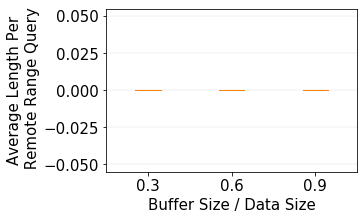

In [30]:
data = [["exp" + str(i) + "_txn_scans_perc" + str(j) for j in [0, 25, 50, 75, 100]] for i in range(2, 5)]
fig, ax = plt.subplots()
i = 1
xvals = num_scans.index.levels[1][:-1]
ax.boxplot([num_scans.loc["OBJBUF"].loc[x, data[i]] for x in xvals], vert=True, patch_artist=True, 
           labels=[0.3, 0.6, 0.9], showfliers=False)
ax.set_xlabel("Buffer Size / Data Size")
ax.set_ylabel("Average Length Per\n Remote Range Query")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
fig.set_size_inches(4.5, 3)
path = "/Users/scarlet/Desktop/Bonsai/figures/"
#fig.savefig(path + "ycsbe_10g_fanout250_limit16k_num_queries.pdf", bbox_inches="tight") 

In [31]:
remote_req = get_compare(col="remote_scans_", divided_by="corrected_scan_commit_cnt", use_diff=True)
remote_req

exp2      exp3      exp4   diff3_2   diff4_2
g_buf_type g_total_buf_sz                                                  
NOBUF      3000000000      1.001481  1.002127  1.001529  0.000646  0.000048
OBJBUF     3000000000      0.167023  0.167285  0.166534  0.000262 -0.000489
           6000000000      0.082307  0.082428  0.081699  0.000121 -0.000608
           9000000000      0.029075  0.029462  0.029126  0.000388  0.000052
           15000000000     0.000000  0.000000  0.000000  0.000000  0.000000
PGBUF      3000000000      0.000000  0.000000  0.000000  0.000000  0.000000
           6000000000      0.000000  0.000000  0.000000  0.000000  0.000000
           9000000000      0.000000  0.000000  0.000000  0.000000  0.000000
           15000000000     0.000000  0.000000  0.000000  0.000000  0.000000

In [32]:
page_req = get_compare(col="remote_rds_", divided_by="corrected_scan_commit_cnt", use_diff=True)
page_req["exp3"].loc["PGBUF"]

g_total_buf_sz
3000000000     2.479378
6000000000     1.532089
9000000000     0.874310
15000000000    0.000003
Name: exp3, dtype: float64

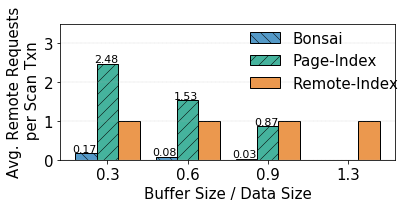

In [39]:
def make_bar_graph_obj(df, df2, col, ylabel="Abort Rate", scale=1, ylim=-1):
    # set values
    xvals = df.index.levels[1]
    xticks = np.arange(len(xvals)) 
    # set format
    bar_space = 0.2
    width = (1.0 - bar_space) / 3
    fig, ax = plt.subplots(1, 1)
    # OBJBUF
    vals1 = df.loc["OBJBUF", col] * scale
    ax.bar(xticks, vals1, label="Bonsai",
           width=width, edgecolor="black", hatch="\\\\", facecolor=bar_colors["BLUE"])
    # PAGEBUF
    vals2 = df2.loc["PGBUF", col] * scale
    ax.bar(xticks + width, vals2, label="Page-Index",
           width=width, edgecolor="black", hatch="//", facecolor=bar_colors["GREEN"])
    # NOBUF
    vals3 = np.repeat(df.loc["NOBUF", col].values * scale, len(df.loc["OBJBUF", col]))
    ax.bar(xticks + width*2, vals3, label="Remote-Index",
           width=width, edgecolor="black", facecolor=bar_colors["ORANGE"])
    if ylim != -1:
        ax.set_ylim(0, ylim)
    plt.xticks(xticks + width, ["0.3", "0.6", "0.9", "1.3"])
    ax.set_xlabel("Buffer Size / Data Size")
    ax.set_ylabel(ylabel)
    fig.set_size_inches(6, 2.5)
    plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
    plt.legend(frameon=False, loc='upper left') 
    for i in range(3):
        ax.text(i+width*0.5, vals1.iloc[i] + 0.03, "%.2f" % vals1.iloc[i], color="black", 
                size=11, ha='right')
        ax.text(i+width*1.5, vals2.iloc[i] + 0.03, "%.2f" % vals2.iloc[i], color="black", 
                size=11, ha='right')
        #ax.text(i+width*2.0, 1.03, "1", color="black", size=11, ha='right')
    return fig, ax, vals1, vals3
fig, ax, val1, val3 = make_bar_graph_obj(remote_req, page_req, "exp3", ylim=3.5,
                                         ylabel="Avg. Remote I/Os\n per Scan Txn")
plt.legend(frameon=False, ncol=1, columnspacing = 0.2,
           loc='upper right', bbox_to_anchor=(1.05,1.05))
fig.savefig(path + "ycsbe_10g_fanout250_limit16k_misses.pdf", bbox_inches="tight") 

In [162]:
val1

g_total_buf_sz
3000000000     0.167285
6000000000     0.082428
9000000000     0.029462
15000000000    0.000000
Name: exp3, dtype: float64

### Observation 2: 0.6 buffer size的throughput会下降 11% (bonsai), 但page的不变

In [ ]:
get_compare(col="remote_rd_time_ms", divided_by="remote_rds_")

In [107]:
get_compare(col="remote_rd_time_ms", divided_by="remote_rds_")

exp2      exp3      exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000           NaN  4.059524  4.137079         NaN   
OBJBUF     3000000000           NaN  3.850260  4.859959         NaN   
           6000000000           NaN  5.030181  5.014439         NaN   
           9000000000           NaN  4.004931  5.825897         NaN   
           15000000000          NaN       NaN       NaN         NaN   
PGBUF      3000000000      5.202932  5.256277  5.464491    1.025293   
           6000000000      5.362784  5.386582  5.436863    0.443759   
           9000000000      5.611006  5.514903  5.775435   -1.742599   
           15000000000     5.505950  5.852180  6.318150    6.288288   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000             NaN  
OBJBUF     3000000000             NaN  
           6000000000             NaN  
           9000000000             NaN  
           15000000000            NaN  
PGBUF      3000000000        5.027140  
           6000000000        1.381358  
           9000000000        2.930468  
           15000000000      14.751314

In [109]:
get_compare(col="remote_scan_time_ms", divided_by="remote_scans_")

exp2       exp3       exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                                
NOBUF      3000000000      88.796450  96.243172  96.431489    8.386284   
OBJBUF     3000000000      95.294550  90.903863  95.613949   -4.830034   
           6000000000      77.276554  91.546882  84.694162   18.466570   
           9000000000      57.641061  45.887916  53.834378  -25.612722   
           15000000000           NaN        NaN        NaN         NaN   
PGBUF      3000000000            NaN        NaN        NaN         NaN   
           6000000000            NaN        NaN        NaN         NaN   
           9000000000            NaN        NaN        NaN         NaN   
           15000000000           NaN        NaN        NaN         NaN   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000        8.598360  
OBJBUF     3000000000        0.335171  
           6000000000        9.598782  
           9000000000       -7.071101  
           15000000000            NaN  
PGBUF      3000000000             NaN  
           6000000000             NaN  
           9000000000             NaN  
           15000000000            NaN

In [110]:
get_compare(col="remote_scans_", divided_by="corrected_scan_commit_cnt")

/Users/scarlet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


exp2      exp3      exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000      1.001481  1.002127  1.001529    0.064478   
OBJBUF     3000000000      0.167023  0.167285  0.166534    0.156891   
           6000000000      0.082307  0.082428  0.081699    0.147176   
           9000000000      0.029075  0.029462  0.029126    1.333125   
           15000000000     0.000000  0.000000  0.000000         NaN   
PGBUF      3000000000      0.000000  0.000000  0.000000         NaN   
           6000000000      0.000000  0.000000  0.000000         NaN   
           9000000000      0.000000  0.000000  0.000000         NaN   
           15000000000     0.000000  0.000000  0.000000         NaN   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000        0.004763  
OBJBUF     3000000000       -0.293608  
           6000000000       -0.743647  
           9000000000        0.177613  
           15000000000            NaN  
PGBUF      3000000000             NaN  
           6000000000             NaN  
           9000000000             NaN  
           15000000000            NaN

In [115]:
get_compare(col="idx_time_ms", divided_by="commit_cnt_")

exp2       exp3       exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                                
NOBUF      3000000000      88.937882  91.637886  91.817391    3.035832   
OBJBUF     3000000000      15.927059  14.474572  15.161830  -10.034746   
           6000000000       6.367343   7.196852   6.593033   13.027553   
           9000000000       1.680611   1.294096   1.500432  -29.867602   
           15000000000      0.005794   0.005843   0.005457    0.844977   
PGBUF      3000000000       0.308672   0.286226   0.323117   -7.841989   
           6000000000       0.292513   0.353835   0.261284   20.963737   
           9000000000       0.270359   0.256554   0.228669   -5.381051   
           15000000000      0.007184   0.007123   0.006655   -0.846254   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000        3.237664  
OBJBUF     3000000000       -5.047078  
           6000000000        3.544488  
           9000000000      -12.008502  
           15000000000      -6.179908  
PGBUF      3000000000        4.679786  
           6000000000      -11.952405  
           9000000000      -18.231615  
           15000000000      -7.950541

In [116]:
get_compare(col="misses_", divided_by="accesses_")

/Users/scarlet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


exp2          exp3          exp4  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000      5.440313e-01  5.415617e-01  5.462797e-01   
OBJBUF     3000000000      1.596892e-01  1.597962e-01  1.588251e-01   
           6000000000      7.571123e-02  7.689676e-02  7.568803e-02   
           9000000000      2.444517e-02  2.478784e-02  2.500830e-02   
           15000000000     0.000000e+00  0.000000e+00  0.000000e+00   
PGBUF      3000000000      4.389770e-02  4.407040e-02  4.421798e-02   
           6000000000      2.687555e-02  2.697629e-02  2.680022e-02   
           9000000000      1.548735e-02  1.539807e-02  1.536985e-02   
           15000000000     7.743057e-08  4.660675e-08  8.379728e-08   

                           speedup3_2  speedup4_2  
g_buf_type g_total_buf_sz                          
NOBUF      3000000000       -0.456012    0.413281  
OBJBUF     3000000000        0.067036   -0.544063  
           6000000000        1.565848   -0.030656  
           9000000000        1.401754    2.303632  
           15000000000            NaN         NaN  
PGBUF      3000000000        0.393413    0.729613  
           6000000000        0.374842   -0.281066  
           9000000000       -0.579813   -0.764484  
           15000000000     -66.135959    8.222478

In [117]:
get_compare(col="avg_log_latency_ (us)")

exp2      exp3      exp4  speedup3_2  \
g_buf_type g_total_buf_sz                                             
NOBUF      3000000000      12174.60  12638.00  11592.60    3.806285   
OBJBUF     3000000000       3403.36   2958.12   3156.89  -15.051452   
           6000000000       1863.84   1983.76   1894.54    6.434029   
           9000000000       2021.06   2408.43   2186.96   19.166675   
           15000000000      1996.91   2370.42   2260.39   18.704398   
PGBUF      3000000000       5534.77   5640.04   5585.80    1.901976   
           6000000000       3954.68   4069.24   3964.31    2.896821   
           9000000000       2926.63   3091.71   2898.12    5.640617   
           15000000000      2058.49   2408.18   2219.20   16.987695   

                           speedup4_2  
g_buf_type g_total_buf_sz              
NOBUF      3000000000       -5.020444  
OBJBUF     3000000000       -7.807367  
           6000000000        1.647137  
           9000000000        8.208564  
           15000000000      13.194385  
PGBUF      3000000000        0.921990  
           6000000000        0.243509  
           9000000000       -0.983741  
           15000000000       7.807179

In [120]:
compare_rw_ro(col="more_than_one_scan_txns_", divided_by="corrected_scan_commit_cnt")

/Users/scarlet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


rw        ro  speedup_rw_ro
g_buf_type g_total_buf_sz                                   
OBJBUF     3000000000      0.002593  0.002659       2.540718
           6000000000      0.002575  0.002312     -11.383925
           9000000000      0.001561  0.001489      -4.835519
           15000000000     0.000000  0.000000            NaN